# 라이브러리

In [1]:
# !pip install koreanize-matplotlib
# !pip install nibabel
# !pip install imutils
# !pip install nilearn
# !pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# 일반
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import koreanize_matplotlib
import numpy as np
import random
import tqdm as tqdm
import seaborn as sns
from tqdm import tqdm, trange
import warnings

# 경로 처리
import os
from pathlib import Path
from glob import glob

# 이미지 처리
import cv2
from PIL import Image
import matplotlib.image as img
import nibabel as nib
from skimage import transform
from scipy.ndimage import rotate
import imutils
import nilearn.plotting as plotting

# 모델링
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import BatchNormalization
from tensorflow.keras.initializers import HeNormal,HeUniform,GlorotNormal,GlorotUniform
from keras.models import Model
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import h5py
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential

In [3]:
warnings.filterwarnings(action = 'ignore')
plt.style.use('ggplot')

# 지민

In [4]:
def jm_imgae_path():
    root_dir = 'Dataset/'

    # root_dir 경로 안에 있는 폴더마다 img가져오고, 폴더명을 y값으로 저장
    img_list = []
    folder_list = []
    for folder_name in os.listdir(root_dir):
        for img in os.listdir(root_dir + folder_name):
            img_list.append(Image.open(f'{root_dir}/{folder_name}/{img}'))  # img 가져오기
            folder_list.append(folder_name)  # folder_name을 y값으로 저장

    # group명 변경하기
    # 기존 : 4개 그룹 => 변경 : 3개 그룹(non, mild, moderate)
    group_list = []
    for folder in folder_list :
        if folder == 'Non_Demented': 
            group_list.append('non')
        elif folder == 'Very_Mild_Demented': 
            group_list.append('mild')
        elif (folder == 'Mild_Demented' or folder == 'Moderate_Demented'): 
            group_list.append('moderate')

    return img_list, group_list

In [5]:
img_list, group_list = jm_imgae_path()

In [6]:
def jm_preprocessing():
    # X값으로 사용할 데이터 (위의 img를 np.array형태로 변환해서 저장) 
    X = [np.array(img) for img in img_list]

    # 이미지 array의 값을 0~1로 정규화
    X = np.array(X)/255

    # group_list의 group이름을 숫자로 인코딩 > y에 담아주기 (정답값)
    y = []
    for group_name in group_list :
        if group_name=='non': y.append(0)
        elif group_name=='mild': y.append(1)
        elif group_name=='moderate' : y.append(2)
        
    y = to_categorical(y)

    X = X.reshape(6400, 128, 128, 1)

    # train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)

    y_train = np.argmax(y_train, axis=1)
    y_test = np.argmax(y_test, axis=1)

    return X_train, X_test, y_train, y_test


In [7]:
X_train, X_test, y_train, y_test = jm_preprocessing()

In [8]:
def jm_model():
    # CNN 모델 생성
    jesus=Sequential()

    #initially 64 convolution nodes
    jesus.add(Conv2D(64,(3,3),padding="same",activation='relu',input_shape=X_train.shape[1:]))
    #add a Max Pooling layer
    jesus.add(MaxPooling2D())

    #another 32 convolution nodes
    jesus.add(Conv2D(32,(3,3),padding="same",activation='relu'))
    #Add a max pooling
    jesus.add(MaxPooling2D())

    #Add 32 convolutions
    jesus.add(Conv2D(32,(2,2),padding="same",activation='relu'))
    #Add a max pooling
    jesus.add(MaxPooling2D())

    #Flatten before adding fully connected layer
    jesus.add(Flatten())

    #Add a hidden layer with 100 nodes
    jesus.add(Dense(100,activation='relu'))

    #Add another hidden layer with 50 nodes
    jesus.add(Dense(50,activation='relu'))

    # Add final ouptput layer : 클래스의 개수대로 만들어줌 (다중분류 softmax)
    jesus.add(Dense(3, activation='softmax'))

    return jesus

In [9]:
jesus = jm_model()

2023-05-09 01:22:35.227851: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 01:22:35.884022: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1553] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14445 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:be:00.0, compute capability: 7.0


In [10]:
def jm_model_fit(jesus):
    chkpt = ModelCheckpoint(filepath='jesus.hdf5', save_best_only=True, save_weights_only=True)

    jesus.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    jesus_history = jesus.fit(X_train, y_train, 
                    validation_split=0.2,
                    shuffle=True,
                    epochs=20,
                    callbacks=[chkpt]
                    )

    return jesus_history

In [11]:
jesus_history = jm_model_fit(jesus)

Epoch 1/20


2023-05-09 01:22:38.442486: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


120/120 [==============================] - 4s 15ms/step - loss: 0.9990 - accuracy: 0.4917 - val_loss: 0.9463 - val_accuracy: 0.5198
Epoch 2/20
120/120 [==============================] - 1s 10ms/step - loss: 0.9059 - accuracy: 0.5529 - val_loss: 0.8604 - val_accuracy: 0.5521
Epoch 3/20
120/120 [==============================] - 1s 11ms/step - loss: 0.8311 - accuracy: 0.5943 - val_loss: 0.8192 - val_accuracy: 0.5823
Epoch 4/20
120/120 [==============================] - 1s 10ms/step - loss: 0.7658 - accuracy: 0.6440 - val_loss: 0.7562 - val_accuracy: 0.6104
Epoch 5/20
120/120 [==============================] - 1s 12ms/step - loss: 0.6462 - accuracy: 0.7083 - val_loss: 0.6216 - val_accuracy: 0.7354
Epoch 6/20
120/120 [==============================] - 1s 11ms/step - loss: 0.4989 - accuracy: 0.7857 - val_loss: 0.5117 - val_accuracy: 0.7875
Epoch 7/20
120/120 [==============================] - 1s 7ms/step - loss: 0.3853 - accuracy: 0.8427 - val_loss: 0.6181 - val_accuracy: 0.7406
Epoch 8/20


# 희묵

In [12]:
def hm_imgae_path():
    # root directory
    root_dir = Path('Dataset')

    # main path
    non_demented = Path(f'{root_dir}/Non_Demented')
    very_mild_demented = Path(f'{root_dir}/Very_Mild_Demented')
    mild_demented = Path(f'{root_dir}/Mild_Demented')
    moderate_demented = Path(f'{root_dir}/Moderate_Demented')

    # images
    non_demented_img = list(non_demented.glob(r'**/*.jpg'))
    very_mild_demented_img = list(very_mild_demented.glob(r'**/*.jpg'))
    mild_demented_img = list(mild_demented.glob(r'**/*.jpg'))
    moderate_demented_img = list(moderate_demented.glob(r'**/*.jpg'))
    
    # series 형태로
    non_demented_series = pd.Series(non_demented_img, name='Non_demented').astype(str)
    very_mild_demented_series = pd.Series(very_mild_demented_img, name='Very_mild_demented').astype(str)
    mild_demented_series = pd.Series(mild_demented_img, name='Mild_demented').astype(str)
    moderate_demented_series = pd.Series(moderate_demented_img, name='Moderate_demented').astype(str)

    # 정렬
    non_demented_series = non_demented_series.sort_values().reset_index(drop=True)
    very_mild_demented_series = very_mild_demented_series.sort_values().reset_index(drop=True)
    mild_demented_series = mild_demented_series.sort_values().reset_index(drop=True)
    moderate_demented_series = moderate_demented_series.sort_values().reset_index(drop=True)

    return non_demented_series, very_mild_demented_series, mild_demented_series, moderate_demented_series

In [13]:
non_demented_series, very_mild_demented_series, mild_demented_series, moderate_demented_series = hm_imgae_path()

In [14]:
def hm_preprocessing(non_demented_series, very_mild_demented_series, mild_demented_series, moderate_demented_series):
    # non_demented
    non = []
    non_label = []

    for _ in non_demented_series:
        img = cv2.cvtColor(cv2.imread(_), cv2.COLOR_BGR2GRAY)
        _, threshold_img = cv2.threshold(img,145,255, cv2.THRESH_BINARY)
        canny_img = cv2.Canny(threshold_img,10,135)
        
        non_label.append('non')
        non.append(canny_img)
        
    # mild_demented
    mild = []
    mild_label = []

    for _ in very_mild_demented_series:
        img = cv2.cvtColor(cv2.imread(_), cv2.COLOR_BGR2GRAY)
        _, threshold_img = cv2.threshold(img,145,255, cv2.THRESH_BINARY)
        canny_img = cv2.Canny(threshold_img,10,135)
        
        mild_label.append('mild')
        mild.append(canny_img)
        
    # moderate_demented
    moderate = []
    moderate_label = []

    for _ in pd.concat([mild_demented_series, moderate_demented_series], axis=0):
        img = cv2.cvtColor(cv2.imread(_), cv2.COLOR_BGR2GRAY)
        _, threshold_img = cv2.threshold(img,145,255, cv2.THRESH_BINARY)
        canny_img = cv2.Canny(threshold_img,10,135)
        
        moderate_label.append('moderate')
        moderate.append(canny_img)
        
    # img를 np.array형태로 변환해서 저장
    X = [np.array(img) for img in non + mild + moderate]

    # array의 값을 0~1로 정규화
    X = np.array(X)/255.
    
    # label 의 group 이름을 숫자로 인코딩 -> y에 담아주기
    y = []
    for label_mapping in non_label + mild_label + moderate_label:
        if label_mapping=='non': 
            y.append(0)
        elif label_mapping=='mild': 
            y.append(1)
        elif label_mapping=='moderate' : 
            y.append(2)
        
    y = to_categorical(y)
    
    # 모델에 넣을 수 있는 형태로 변환
    X = X.reshape(6400, 128, 128, 1)

    # train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)

    y_train = np.argmax(y_train, axis=1)
    y_test = np.argmax(y_test, axis=1)

    return X_train, X_test, y_train, y_test

In [15]:
X_train, X_test, y_train, y_test = hm_preprocessing(non_demented_series, very_mild_demented_series, mild_demented_series, moderate_demented_series)

In [16]:
def hm_model():
    
    input_img = Input(shape=X_train.shape[1:], name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer = HeNormal(), name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer = HeNormal(), name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', kernel_initializer = HeNormal(), name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', kernel_initializer = HeNormal(), name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    x = Dropout(0.1, name='dropout1')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', kernel_initializer = HeNormal(), name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', kernel_initializer = HeNormal(), name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', kernel_initializer = HeNormal(), name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    x = Dropout(0.1, name='dropout2')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', kernel_initializer = HeNormal(), name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', kernel_initializer = HeNormal(), name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', kernel_initializer = HeNormal(), name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    x = Dropout(0.1, name='dropout3')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', kernel_initializer = HeNormal(), name='fc1')(x)
    x = Dense(512, activation='relu', kernel_initializer = HeNormal(), name='fc2')(x)
    x = Dense(3, activation='softmax', kernel_initializer = GlorotNormal(), name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [17]:
heemook = hm_model()

In [18]:
def hm_model_fit(heemook):
    opt = Adam(learning_rate=0.0001, decay=1e-5)
    es = EarlyStopping(patience=4)
    chkpt = ModelCheckpoint(filepath='heemook.hdf5', save_best_only=True, save_weights_only=True)

    heemook.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

    heemook_history = heemook.fit(X_train, y_train, epochs=100, validation_split=0.2,
                                  shuffle=True, callbacks=[es, chkpt],
                                  class_weight = {0: 1.0, 1: 2.0, 2: 2.0})

    return heemook_history

In [19]:
heemook_history = hm_model_fit(heemook)

Epoch 1/100
128/128 [==============================] - 7s 44ms/step - loss: 1.5707 - accuracy: 0.3601 - val_loss: 1.0721 - val_accuracy: 0.3125
Epoch 2/100
128/128 [==============================] - 5s 38ms/step - loss: 1.4782 - accuracy: 0.4734 - val_loss: 1.1067 - val_accuracy: 0.3125
Epoch 3/100
128/128 [==============================] - 4s 34ms/step - loss: 1.4063 - accuracy: 0.5125 - val_loss: 1.0960 - val_accuracy: 0.3125
Epoch 4/100
128/128 [==============================] - 5s 37ms/step - loss: 1.3734 - accuracy: 0.5237 - val_loss: 1.0943 - val_accuracy: 0.3125
Epoch 5/100
128/128 [==============================] - 5s 39ms/step - loss: 1.3035 - accuracy: 0.5449 - val_loss: 1.0306 - val_accuracy: 0.5088
Epoch 6/100
128/128 [==============================] - 5s 37ms/step - loss: 1.2439 - accuracy: 0.5735 - val_loss: 0.8402 - val_accuracy: 0.5576
Epoch 7/100
128/128 [==============================] - 4s 34ms/step - loss: 1.1707 - accuracy: 0.6035 - val_loss: 0.8505 - val_accuracy:

# 정현

In [20]:
def jh_image_path():
        root_dir = 'Dataset/'

        # root_dir 경로 안에 있는 폴더마다 img가져오고, 폴더명을 y값으로 저장
        img_list = []
        folder_list = []
        for folder_name in os.listdir(root_dir):
            for img in os.listdir(root_dir + folder_name):
                img_list.append(Image.open(f'{root_dir}/{folder_name}/{img}'))  # img 가져오기
                folder_list.append(folder_name)  # folder_name을 y값으로 저장

        # group명 변경하기
        # 기존 : 4개 그룹 => 변경 : 3개 그룹(non, mild, moderate)
        group_list = []
        for folder in folder_list :
            if folder == 'Non_Demented': 
                group_list.append('non')
            elif folder == 'Very_Mild_Demented': 
                group_list.append('mild')
            elif (folder == 'Mild_Demented' or folder == 'Moderate_Demented'): 
                group_list.append('moderate')

        # X값으로 사용할 데이터 (위의 img를 np.array형태로 변환해서 저장) 
        X = [np.array(img) for img in img_list]

        # 이미지 array의 값을 0~1로 정규화
        X = np.array(X)/255

        # group_list의 group이름을 숫자로 인코딩 > y에 담아주기 (정답값)
        y = []
        for group_name in group_list :
            if group_name=='non': y.append(0)
            elif group_name=='mild': y.append(1)
            elif group_name=='moderate' : y.append(2)
            
        y = to_categorical(y)

        X = X.reshape(6400, 128, 128, 1)

        # train_test_split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, random_state=42)
        
        y_train = np.argmax(y_train, axis=1)
        y_test = np.argmax(y_test, axis=1)
    
        return X_train, X_test, y_train, y_test

In [21]:
X_train, X_test, y_train, y_test = jh_image_path()

In [22]:
def jh_preprocessing(X_train, y_train):
    # 데이터 증강
    # X_train = np.expand_dims(X_train, axis = -1)

    # 데이터 증강을 위한 ImageDataGenerator 객체 생성
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        vertical_flip = True,
        zoom_range=0.20)

    # 학습 데이터에 데이터 증강된 이미지 추가하기
    BATCH_SIZE = 32
    STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE  #160

    train_datagen = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
    augmented_data = []
    augmented_labels = []
    for i in range(7):  # 증강 횟수
        print(i)
        for j in trange(STEPS_PER_EPOCH):
            batch_x, batch_y = train_datagen.next()
            augmented_data.append(batch_x)
            augmented_labels.append(batch_y)

    X_train_aug = np.concatenate(augmented_data)
    y_train_aug = np.concatenate(augmented_labels)

    # 통일을 위해서 다시 X_train, y_train 으로 변경했습니다.
    X_train_final = np.concatenate((X_train, X_train_aug), axis=0)
    y_train_final = np.concatenate((y_train, y_train_aug), axis=0)
       
    return X_train_final, y_train_final

In [23]:
X_train, y_train = jh_preprocessing(X_train, y_train)

0


100%|██████████| 150/150 [00:04<00:00, 30.43it/s]


1


100%|██████████| 150/150 [00:05<00:00, 29.52it/s]


2


100%|██████████| 150/150 [00:04<00:00, 30.67it/s]


3


100%|██████████| 150/150 [00:04<00:00, 30.31it/s]


4


100%|██████████| 150/150 [00:04<00:00, 30.61it/s]


5


100%|██████████| 150/150 [00:04<00:00, 30.37it/s]


6


100%|██████████| 150/150 [00:04<00:00, 30.43it/s]


In [24]:
def jh_model():
    IMG_HEIGHT,IMG_WIDTH = 128, 128

    jh_model = keras.models.Sequential()

    jh_model.add(keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_normal', input_shape=(IMG_HEIGHT,IMG_WIDTH, 1)))
    jh_model.add(BatchNormalization())  # BatchNormalization 레이어 추가
    jh_model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

    jh_model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_normal'))
    jh_model.add(BatchNormalization())  # BatchNormalization 레이어 추가
    jh_model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    jh_model.add(keras.layers.Dropout(0.30))

    jh_model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.001)))
    jh_model.add(BatchNormalization())  # BatchNormalization 레이어 추가
    jh_model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    jh_model.add(keras.layers.Dropout(0.3))

    jh_model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.001)))
    jh_model.add(BatchNormalization())  # BatchNormalization 레이어 추가
    jh_model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

    jh_model.add(keras.layers.Dropout(0.3))
    jh_model.add(keras.layers.Flatten())
    jh_model.add(keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'))
    jh_model.add(BatchNormalization())  # BatchNormalization 레이어 추가
    jh_model.add(keras.layers.Dropout(0.3))
    jh_model.add(keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'))
    jh_model.add(BatchNormalization())  # BatchNormalization 레이어 추가
    jh_model.add(keras.layers.Dense(3, activation='softmax', kernel_initializer = GlorotNormal()))

    return jh_model


In [25]:
junghyun = jh_model()

In [26]:
def jh_model_fit(junghyun):
    junghyun.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy"])

    early_stop = EarlyStopping(monitor='val_loss', patience=5)

    learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                                patience =2 , verbose = 1,
                                                factor = 0.2, min_lr = 0.000001)

    chkpt = ModelCheckpoint(filepath='junghyun.hdf5', save_best_only=True, save_weights_only=True)

    junghyun_history = junghyun.fit(X_train, y_train, validation_split = 0.2,
                            epochs=50, batch_size=64,
                            callbacks = [learning_rate_reduction, chkpt], verbose=1)

    return junghyun_history

In [27]:
junghyun_history = jh_model_fit(junghyun)

Epoch 1/50
480/480 [==============================] - 8s 14ms/step - loss: 1.2686 - accuracy: 0.5346 - val_loss: 3.1951 - val_accuracy: 0.5090 - lr: 0.0010
Epoch 2/50
480/480 [==============================] - 6s 12ms/step - loss: 1.0477 - accuracy: 0.5910 - val_loss: 1.2227 - val_accuracy: 0.5402 - lr: 0.0010
Epoch 3/50
480/480 [==============================] - 6s 13ms/step - loss: 0.9310 - accuracy: 0.6095 - val_loss: 0.9246 - val_accuracy: 0.6040 - lr: 0.0010
Epoch 4/50
480/480 [==============================] - 6s 12ms/step - loss: 0.8610 - accuracy: 0.6303 - val_loss: 0.9319 - val_accuracy: 0.5984 - lr: 0.0010
Epoch 5/50
480/480 [==============================] - 6s 12ms/step - loss: 0.8062 - accuracy: 0.6486 - val_loss: 0.8045 - val_accuracy: 0.6438 - lr: 0.0010
Epoch 6/50
480/480 [==============================] - 6s 12ms/step - loss: 0.7686 - accuracy: 0.6695 - val_loss: 0.8068 - val_accuracy: 0.6404 - lr: 0.0010
Epoch 7/50
480/480 [==============================] - 6s 12ms/st

# history, confusion matrix, ROC

In [28]:
name = ['지민', '희묵', '정현']
model_spe = ['Contour', 'Canny', 'Augmentation']

hist = []
hist.extend([jesus_history, heemook_history, junghyun_history])

for _, i in zip(name, hist):
    print('\n\n', _)
    display(pd.DataFrame(i.history))
    print('\n')



 지민


,loss,accuracy,val_loss,val_accuracy
0,0.998997,0.491667,0.946319,0.519792
1,0.905909,0.552865,0.860392,0.552083
2,0.831095,0.594271,0.819158,0.582292
3,0.765772,0.644010,0.756184,0.610417
4,0.646207,0.708333,0.621577,0.735417
5,0.498870,0.785677,0.511747,0.787500
6,0.385319,0.842708,0.618125,0.740625
7,0.264684,0.897656,0.368641,0.866667
8,0.184481,0.928385,0.299610,0.890625
9,0.149276,0.945052,0.366149,0.870833






 희묵


,loss,accuracy,val_loss,val_accuracy
0,1.570653,0.360107,1.072078,0.312500
1,1.478183,0.473389,1.106688,0.312500
2,1.406318,0.512451,1.096023,0.312500
3,1.373410,0.523682,1.094303,0.312500
4,1.303514,0.544922,1.030574,0.508789
5,1.243943,0.573486,0.840157,0.557617
6,1.170687,0.603516,0.850452,0.583984
7,1.048687,0.659180,0.749633,0.641602
8,0.939775,0.702148,0.724537,0.665039
9,0.840900,0.731201,0.669284,0.688477






 정현


,loss,accuracy,val_loss,val_accuracy,lr
0,1.268563,0.534635,3.195091,0.508984,0.001000
1,1.047714,0.591016,1.222689,0.540234,0.001000
2,0.931021,0.609505,0.924600,0.604036,0.001000
3,0.860984,0.630273,0.931857,0.598437,0.001000
4,0.806212,0.648633,0.804540,0.643750,0.001000
5,0.768635,0.669531,0.806827,0.640365,0.001000
6,0.734105,0.689876,0.756804,0.674349,0.001000
7,0.708157,0.709342,0.686556,0.717448,0.001000
8,0.698804,0.718783,0.694198,0.726562,0.001000
9,0.680690,0.732422,0.724059,0.711589,0.001000


In [29]:
# fig, ax = plt.subplots(3, 2, figsize=(10, 10))

# ax = ax.flatten()
# count = 0
# cnt = 0

# for i in hist:

#     df_hist = pd.DataFrame(i.history)[['loss', 'val_loss', 'accuracy', 'val_accuracy']]
#     lss = round(df_hist.iloc[-1, 0], 5)
#     val_lss = round(df_hist.iloc[-1, 1], 5)
#     accrcy = round(df_hist.iloc[-1, 2], 2)
#     val_accrcy = round(df_hist.iloc[-1, 3], 2)

#     epochs = range(len(df_hist))
#     ax[count].plot(epochs, df_hist['loss'], label = f'train_loss \n {lss}')
#     ax[count].plot(epochs, df_hist['val_loss'], label = f'valid_loss \n {val_lss}')
#     ax[count].legend(loc='upper right', frameon=False)
    
#     ax[count+1].plot(epochs, df_hist['accuracy'], label = f'train_accuracy \n {accrcy}')
#     ax[count+1].plot(epochs, df_hist['val_accuracy'], label = f'valid_accuracy \n {val_accrcy}')
#     ax[count+1].legend(loc='lower right', frameon=False)
    
#     ax[count].set_title(f'{model_spe[cnt]} loss')
#     ax[count+1].set_title(f'{model_spe[cnt]} accuarcy')

#     ax[count].set_xticks(np.arange(1,len(df_hist)+1,int(len(df_hist) / 6)))
#     ax[count+1].set_xticks(np.arange(1,len(df_hist)+1,int(len(df_hist) / 6)))
    
#     cnt += 1
#     count += 2
# plt.tight_layout()


In [30]:
def kimohchoi_hist(history):
    fontdict = {'fontfamily':'serif', 'fontstyle':'italic'}

    if history == jesus_history.history :
        name = 'Contour'
    if history == heemook_history.history :
        name = 'Canny'
    if history == junghyun_history.history :
        name = 'Augmentation'

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax = ax.flatten()

    df_hist = pd.DataFrame(history)[['loss', 'val_loss', 'accuracy', 'val_accuracy']]
    lss = round(df_hist.iloc[-1, 0], 5)
    val_lss = round(df_hist.iloc[-1, 1], 5)
    accrcy = round(df_hist.iloc[-1, 2], 2)
    val_accrcy = round(df_hist.iloc[-1, 3], 2)

    epochs = range(len(df_hist))
    iteration = len(df_hist)
    
    ax[0].plot(epochs, df_hist['loss'], label = f'train_loss \n {lss}')
    ax[0].plot(epochs, df_hist['val_loss'], label = f'valid_loss \n {val_lss}')
    ax[0].legend(loc='upper right', frameon=False)

    ax[1].plot(epochs, df_hist['accuracy'], label = f'train_accuracy \n {accrcy}')
    ax[1].plot(epochs, df_hist['val_accuracy'], label = f'valid_accuracy \n {val_accrcy}')
    ax[1].legend(loc='lower right', frameon=False)

    ax[0].set_title('loss', **fontdict)
    ax[1].set_title('accuracy', **fontdict)

    ax[0].set_xticks(np.arange(1,iteration+1,int(iteration / 6)))
    ax[1].set_xticks(np.arange(1,iteration+1,int(iteration / 6)))

    ax[0].set_xlabel('epochs')
    ax[1].set_xlabel('epochs')
    ax[0].set_ylabel('loss')
    ax[1].set_ylabel('accuracy')

    fig.suptitle(name, fontsize=20, weight='bold')
    
    plt.tight_layout()

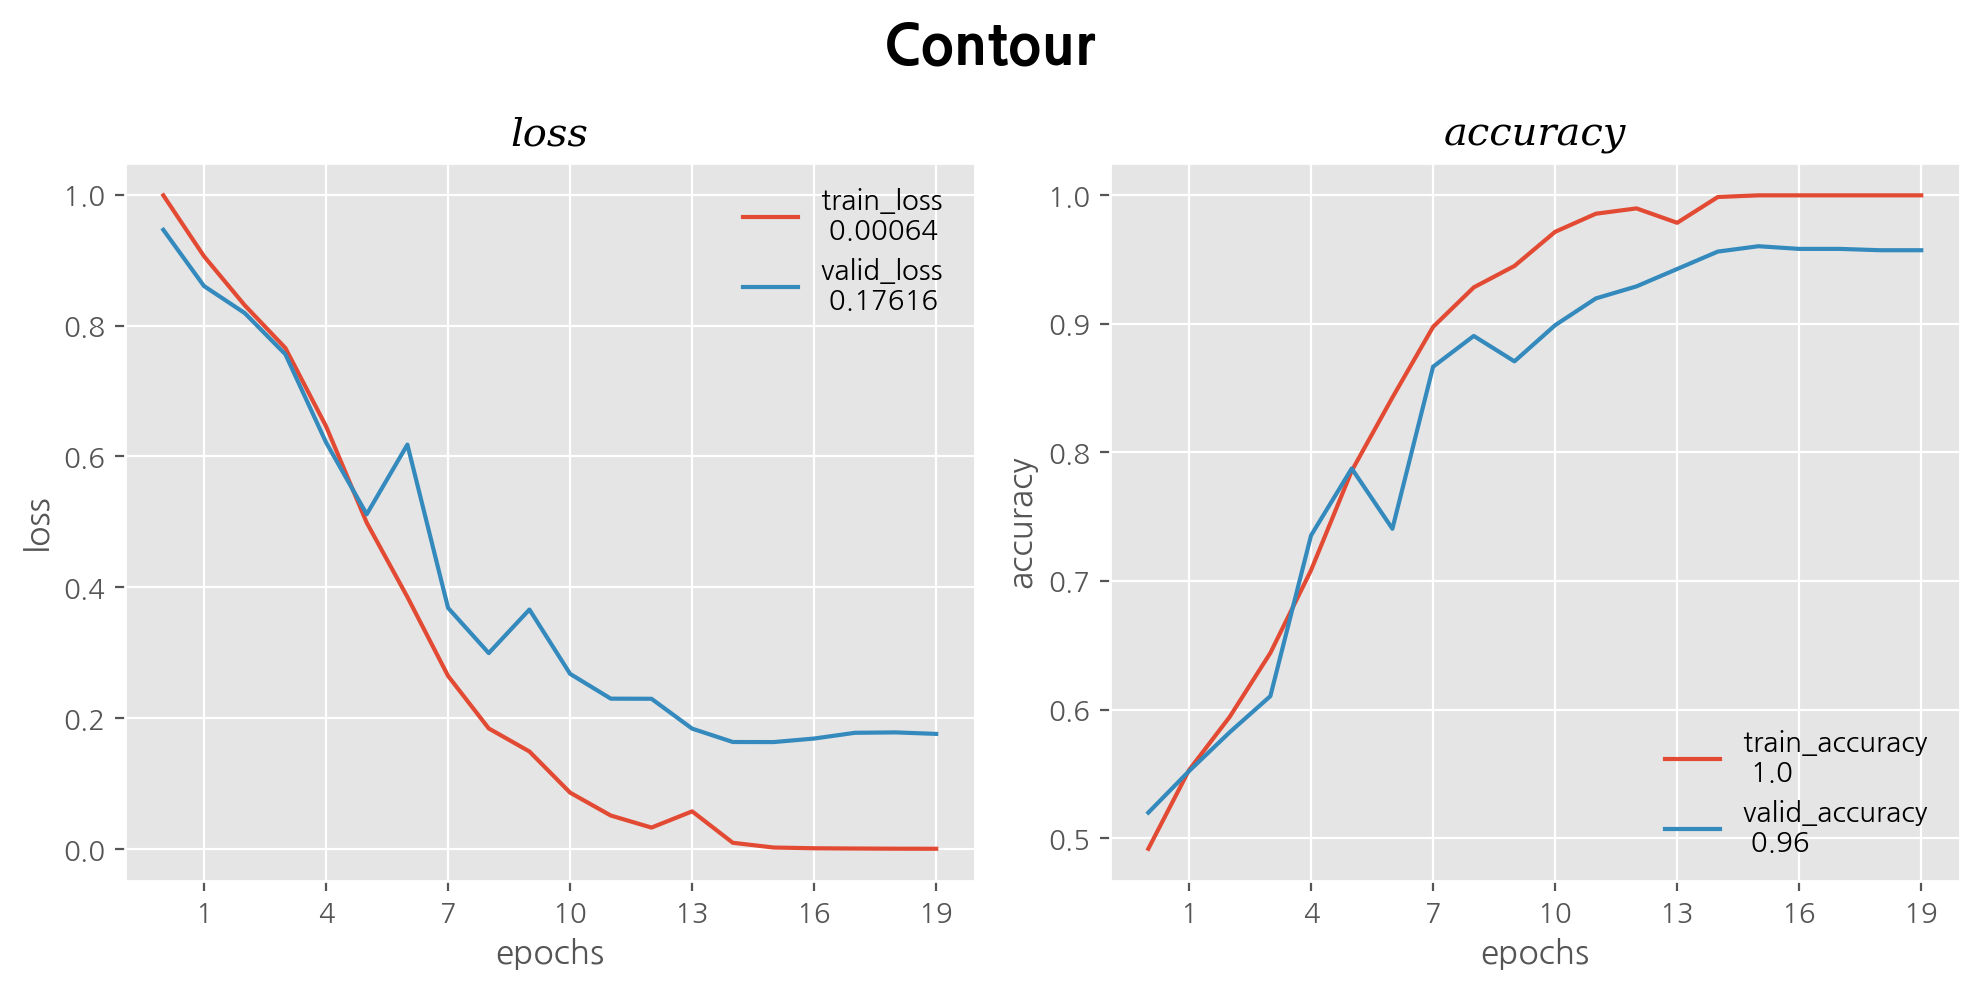

In [31]:
kimohchoi_hist(jesus_history.history)

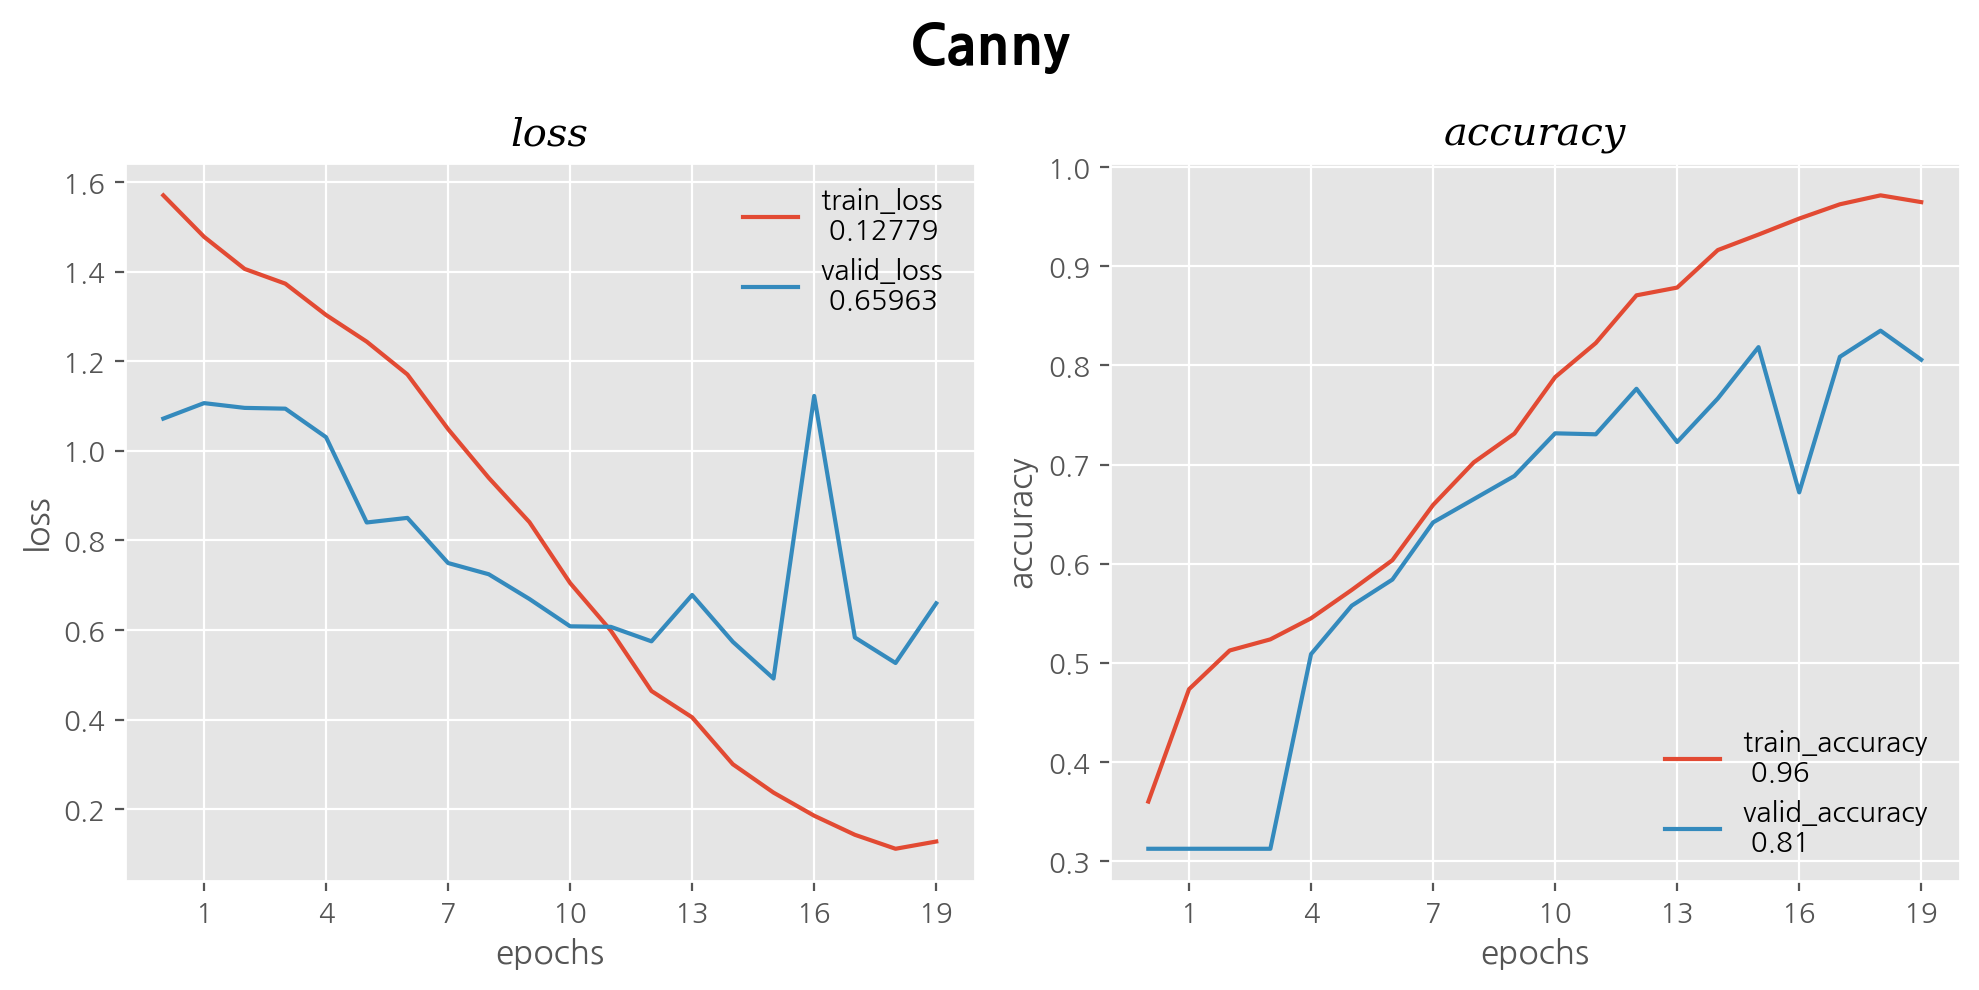

In [32]:
kimohchoi_hist(heemook_history.history)

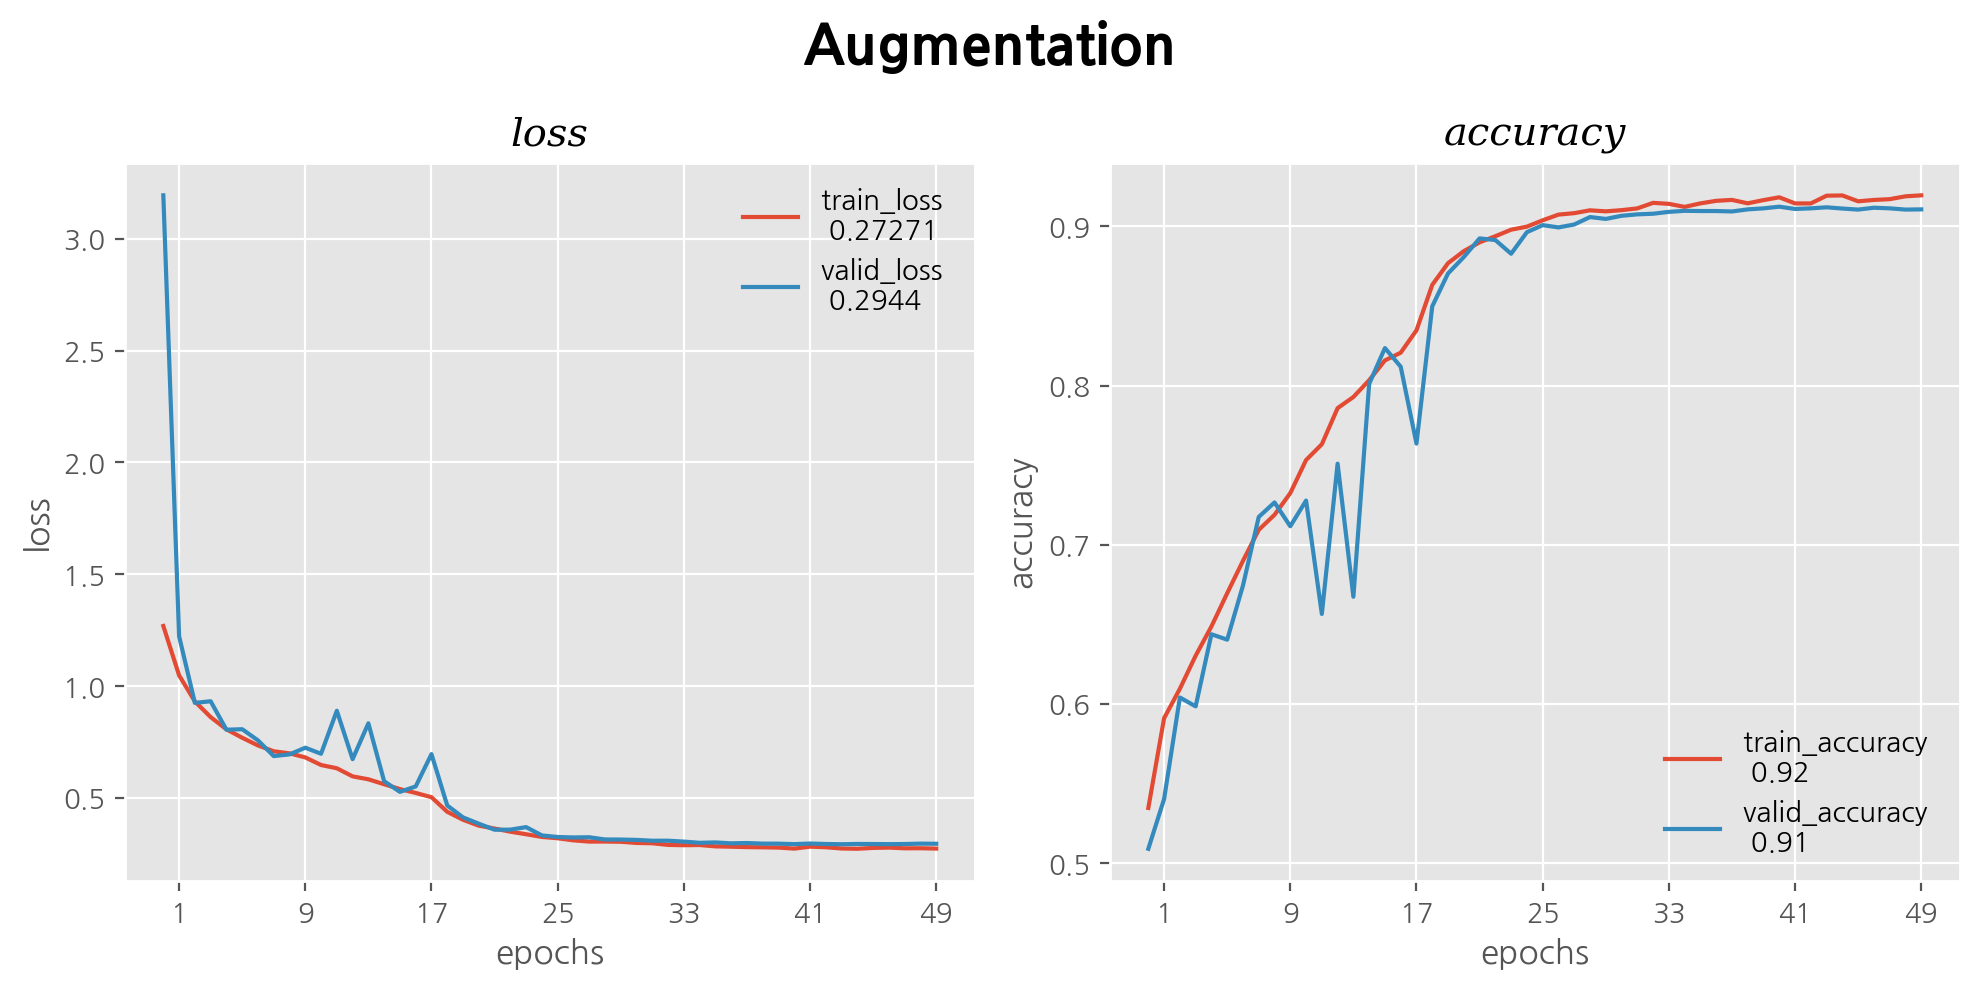

In [33]:
kimohchoi_hist(junghyun_history.history)

In [63]:
def kimohchoi_cm(model, feature, label):
    fontdict = {'fontfamily':'serif', 'fontstyle':'italic'}

    if model == jesus :
        name = 'Contour'
    if model == heemook :
        name = 'Canny'
    if model == junghyun :
        name = 'Augmentation'

    y_pred = model.predict(feature, verbose=0)
    y_pred = [np.argmax(y) for y in y_pred]

    cm = confusion_matrix(label, y_pred)
    cm = pd.DataFrame(cm, columns=['pred_none', 'pred_mild', 'pred_moderte'], index=['real_none', 'real_mild', 'real_moderate'])

    plt.figure(figsize=(5, 5))
    ax = sns.heatmap(data=cm, annot=True, fmt='g', cmap='Blues', cbar=False, linewidths=10)

    ax.tick_params(axis='x', labeltop=True, labelbottom=False)
    ax.set_yticklabels(ax.get_yticklabels(), va='center')

    ax.set_title(f'{name} confusion matrix\n', fontsize=20, weight='bold') 


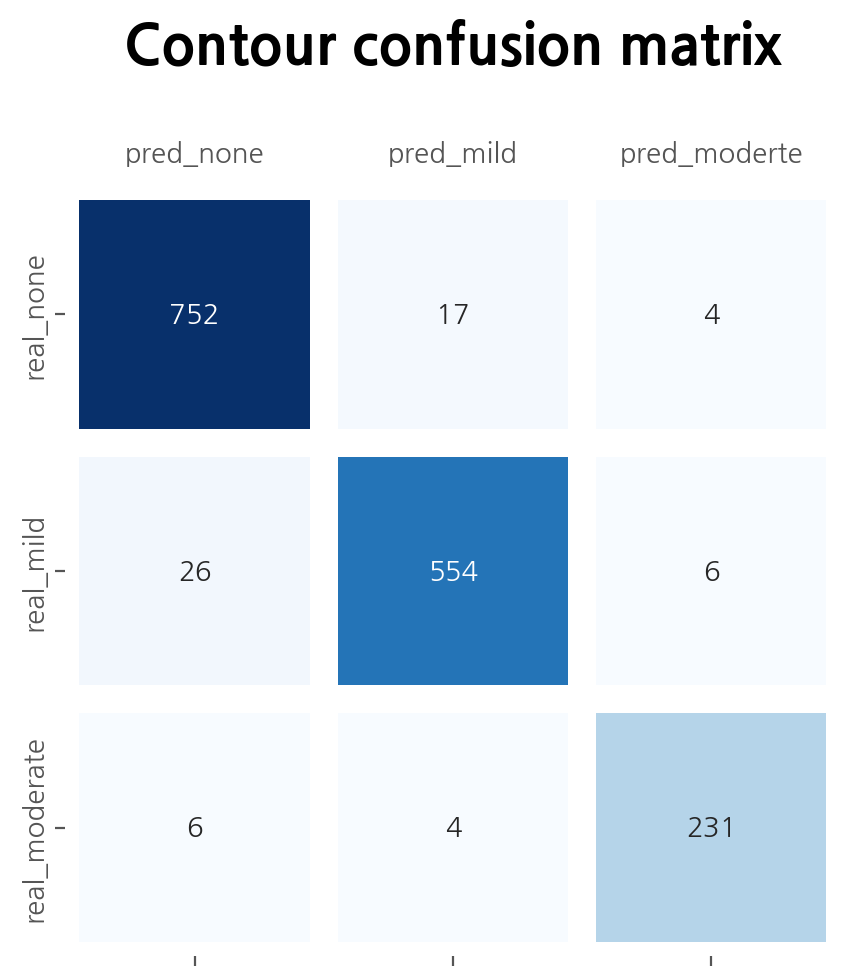

In [64]:
kimohchoi_cm(jesus, X_test, y_test)

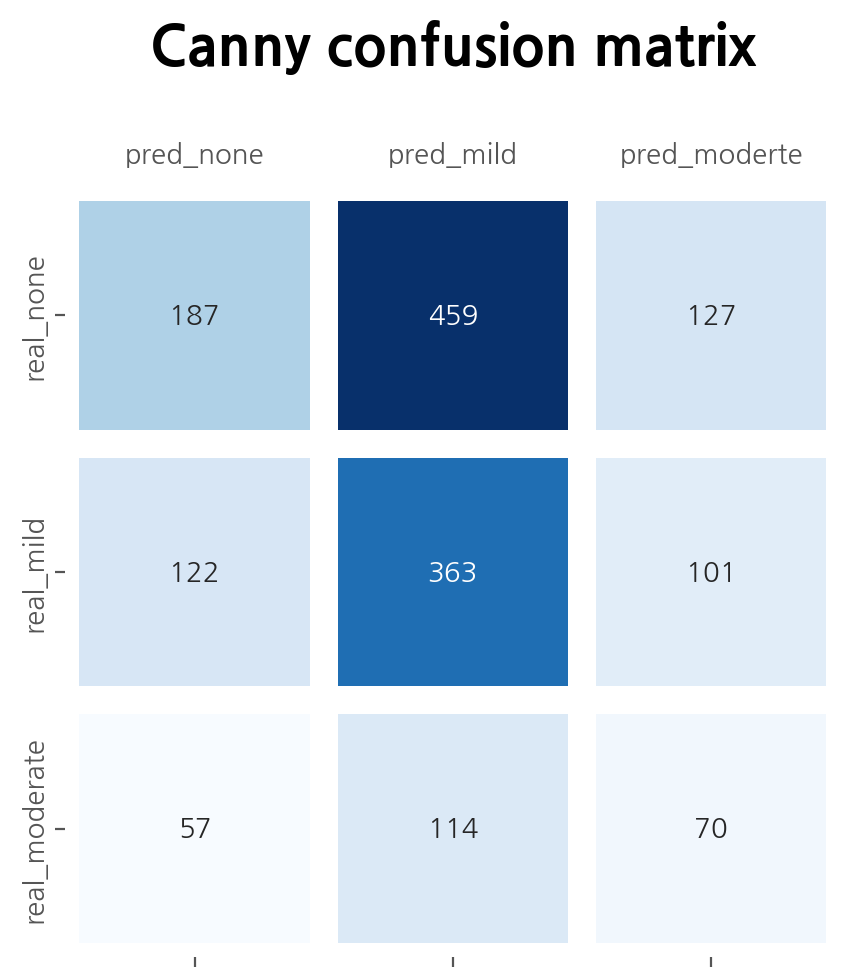

In [65]:
kimohchoi_cm(heemook, X_test, y_test)

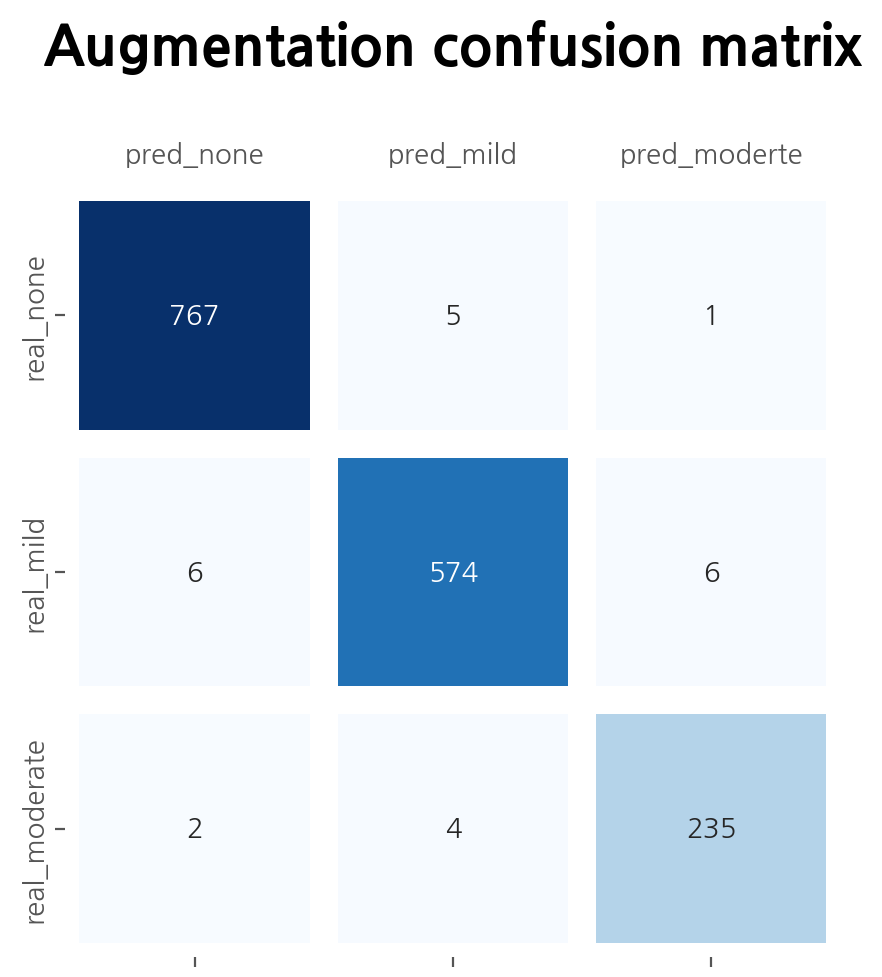

In [66]:
kimohchoi_cm(junghyun, X_test, y_test)

# 오아시스 데이터 셋으로 진행

In [38]:
# OASIS-2 Demographic data
df_demographic = pd.read_excel('../OASIS-2 dataset/demographics.xlsx')

# MRI ID
MRI_IDs = list(df_demographic['MRI ID'])

# group명 변경하기
# 기존 : 4개 그룹 => 변경 : 3개 그룹(non, mild, moderate)
demented_list = []
for cdr in df_demographic["CDR"] :
    if cdr == 0. : 
        demented_list.append('non')
    elif cdr == 0.5: 
        demented_list.append('mild')
    elif (cdr == 1. or cdr == 2.): 
        demented_list.append('moderate')
    
# 치매군을 3개로 나누어 파생변수 생성
df_demographic["demented"] = demented_list

# MRI가 불러와지는 경우 MRI_paths에 파일 경로 저장
MRI_paths = []
for MRI_ID in tqdm(MRI_IDs):
    img_paths = sorted(glob(f'../OASIS-2 dataset/{MRI_ID}/*.nifti.img'))
    for img_path in img_paths:
        try:
            nib.load(img_path).get_fdata()
            MRI_paths.append(img_path)
        except:
            pass

        
# MRI_ID 기준 겹치는 부분 제거 => 220개 -> 60개
MRI_paths.sort() 

i=0
while i < len(MRI_paths) -1:
        current_str = MRI_paths[i]
        next_str = MRI_paths[i+1]
        
        if current_str.split("/")[2] in next_str :
            MRI_paths.remove(current_str)
        else :
            i +=1
MRI_paths

100%|██████████| 373/373 [01:14<00:00,  5.01it/s]


['../OASIS-2 dataset/OAS2_0004_MR2/mpr-4.nifti.img',
 '../OASIS-2 dataset/OAS2_0005_MR1/mpr-4.nifti.img',
 '../OASIS-2 dataset/OAS2_0005_MR2/mpr-3.nifti.img',
 '../OASIS-2 dataset/OAS2_0005_MR3/mpr-3.nifti.img',
 '../OASIS-2 dataset/OAS2_0007_MR1/mpr-4.nifti.img',
 '../OASIS-2 dataset/OAS2_0007_MR3/mpr-4.nifti.img',
 '../OASIS-2 dataset/OAS2_0007_MR4/mpr-3.nifti.img',
 '../OASIS-2 dataset/OAS2_0008_MR1/mpr-4.nifti.img',
 '../OASIS-2 dataset/OAS2_0008_MR2/mpr-4.nifti.img',
 '../OASIS-2 dataset/OAS2_0009_MR1/mpr-4.nifti.img',
 '../OASIS-2 dataset/OAS2_0009_MR2/mpr-4.nifti.img',
 '../OASIS-2 dataset/OAS2_0010_MR1/mpr-4.nifti.img',
 '../OASIS-2 dataset/OAS2_0010_MR2/mpr-3.nifti.img',
 '../OASIS-2 dataset/OAS2_0012_MR1/mpr-4.nifti.img',
 '../OASIS-2 dataset/OAS2_0012_MR2/mpr-4.nifti.img',
 '../OASIS-2 dataset/OAS2_0012_MR3/mpr-3.nifti.img',
 '../OASIS-2 dataset/OAS2_0013_MR1/mpr-4.nifti.img',
 '../OASIS-2 dataset/OAS2_0013_MR2/mpr-4.nifti.img',
 '../OASIS-2 dataset/OAS2_0013_MR3/mpr-3.nifti

In [39]:
# MRI_path 정보도 MRI_ID, mpr, demographic data 포함한 데이터프레임 생성
df_OASIS2 = pd.DataFrame(MRI_paths)
df_OASIS2.columns = ['MRI_path']
df_OASIS2['MRI_ID'] = df_OASIS2['MRI_path'].str[19:32]
df_OASIS2['mpr'] = df_OASIS2['MRI_path'].str[33:38]
df_OASIS2 = pd.merge(df_OASIS2, df_demographic, left_on='MRI_ID', right_on='MRI ID')
df_OASIS2 = df_OASIS2.drop(columns=['MRI ID'])
df_OASIS2 = df_OASIS2[['Subject ID', 'MRI_ID',  'Group', 'demented']]
df_OASIS2

df_slicenum = pd.read_csv("df_OASIS2_slicenum.csv")
df_OASIS2["slice_num"] = df_slicenum["slice_num"]
df_OASIS2.head(2)

,Subject ID,MRI_ID,Group,demented,slice_num
0,OAS2_0004,OAS2_0004_MR2,Nondemented,non,170
1,OAS2_0005,OAS2_0005_MR1,Nondemented,non,170


## Original OASIS-2 Data import

In [40]:
og_oas_list = []
for i, img in tqdm(enumerate(MRI_paths)):
    og_oas_img = nib.load(img)
#     plotting.plot_epi(oas_og_img)
    data = og_oas_img.get_fdata()
    og_oas_list.append(data[:,df_OASIS2["slice_num"][i],:])
    
    
#     oas_og_img = [ np.array(img) for img in oas_og_img]
og_oas_list

60it [00:04, 14.40it/s]


[array([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        ...,
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]]),
 array([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        ...,
 
       

### og_oas_X_test

(60, 128, 128, 1)

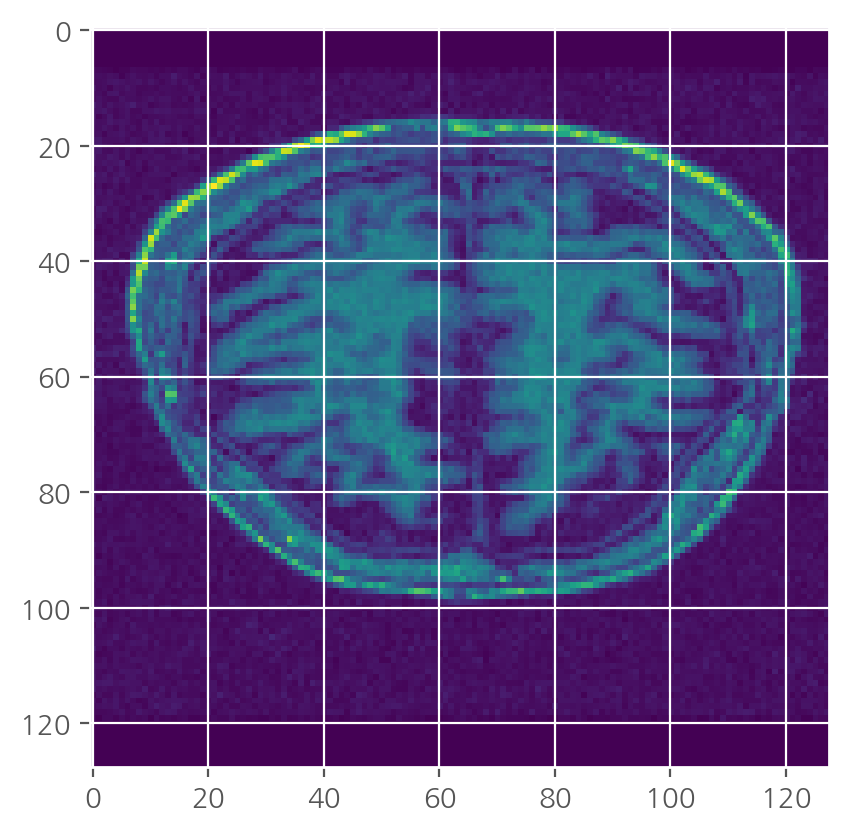

In [41]:
og_oas_X_list = []
for img in og_oas_list :
    

    
    og_oas_resized_img = cv2.resize(img, (128,128))
#     og_oas_gray_img = cv2.cvtColor(og_oas_resized_img, cv2.COLOR_RGB2GRAY) 
    og_oas_gray_img = np.expand_dims(og_oas_resized_img, axis=-1)
    og_oas_X_list.append(og_oas_gray_img)

# np.array로 변경
og_oas_X = [np.array(img) for img in og_oas_X_list]


# 이미지 array의 값을 0~1로 정규화
og_oas_X_test = np.array(og_oas_X) /255
og_oas_X_test.shape[0]

plt.imshow(og_oas_X_test[1])
og_oas_X_test.shape


### og_oas_y_test

In [42]:
og_oas_y_test = []

for i in df_OASIS2["demented"].tolist():
    if i == 'non' : 
        og_oas_y_test.append(0)
    elif i == 'mild': 
        og_oas_y_test.append(1)
    elif (i == 'moderate'): 
        og_oas_y_test.append(2)
len(og_oas_y_test)

set(og_oas_y_test)

{0, 1, 2}

In [43]:
og_oas_y_test = np.array(og_oas_y_test)
# og_oas_y_test = to_categorical(og_oas_y_test)
og_oas_y_test.shape

(60,)

In [44]:
def preprocess_brain_img1(original_img, line_width=30, skull_included=1):
    """
    MRI 원본파일경로, 적용 정도, 두개골 포함 여부 
    -> 두개골을 제거하고 (128, 128, 1)로 resize된 이미지를 리턴하는 함수
    """
    margins=5

    # 1. gray_scaled
    _, encoded_img = cv2.imencode('.jpg', original_img)
    decoded_img = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)
#     gray_scaled = cv2.imread(decoded_img, cv2.IMREAD_GRAYSCALE)
    gray_scaled = cv2.cvtColor(decoded_img, cv2.COLOR_RGB2GRAY) 
    gray_scaled = cv2.GaussianBlur(gray_scaled, ksize=(5, 5), sigmaX=0)
    resized = cv2.resize(gray_scaled, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

    # 2. 두개골 제거
    if skull_included==1 :
        thresh = cv2.threshold(resized.copy(), thresh=45, maxval=255, 
                               type=cv2.THRESH_BINARY)[1]  # thresh : 임계치를 기준으로 흑백(binary)이미지로 변형
        thresh = cv2.dilate(thresh, None, iterations=3)  # dilate : 흰색 픽셀을 확장 
        thresh = cv2.erode(thresh, None, iterations=1)  # erode : 검은색 픽셀을 축소

        # 3. contour_skull : 지울 범위 확인
        contours = cv2.findContours(thresh.copy(), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
        contours = imutils.grab_contours(contours)  # tuple값을 list형태로 간결하게
        contour = max(contours, key=cv2.contourArea)  # 찾은 contours 중에서 max값
        without_skull = cv2.drawContours(image=resized.copy(), # 원본 이미지 위에 contour 표시하기
                                       contours=[contour],  # contour를 리스트 형태로 해주지 않으면 선이 끊어지게 나옴. 
                                       contourIdx=-1,  # contourIdx는 0, -1 중에 
                                       color=(0, 0, 0), thickness=line_width)  # 검정색으로 thinckness만큼 덮어버리기
    else : 
        without_skull = resized

    # 3. contour - extreme point - crop
    thresh_brain = cv2.threshold(without_skull, thresh=45, maxval=255, type=cv2.THRESH_BINARY)[1] 
    thresh_brain = cv2.dilate(thresh_brain, None, iterations=2) 
    thresh_brain = cv2.erode(thresh_brain, None, iterations=1) 

    contours_brain = cv2.findContours(thresh_brain.copy(), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    contours_brain = imutils.grab_contours(contours_brain)  
    contour_brain = max(contours_brain, key=cv2.contourArea) 
    contour_brain_img = cv2.drawContours(image=without_skull.copy(), contours=[contour_brain], contourIdx=-1,  
                                   color=(0, 255, 255), thickness=2) 

    x좌표, y좌표 = contour_brain[:, :, 0], contour_brain[:, :, 1]
    left_point = tuple(contour_brain[x좌표.argmin()][0])
    right_point = tuple(contour_brain[x좌표.argmax()][0])
    top_point = tuple(contour_brain[y좌표.argmax()][0])
    bottom_point = tuple(contour_brain[y좌표.argmin()][0])

    ext_point = cv2.circle(contour_brain_img.copy(), center=left_point, radius=8, color=(255, 0, 255), thickness=-1)
    ext_point = cv2.circle(ext_point.copy(), center=right_point, radius=8, color=(0, 255, 255), thickness=-1)
    ext_point = cv2.circle(ext_point.copy(), center=top_point, radius=8, color=(255, 0, 0), thickness=-1)
    ext_point = cv2.circle(ext_point.copy(), center=bottom_point, radius=8, color=(255, 255, 0), thickness=-1)

    bottom = bottom_point[1]-margins if bottom_point[1]-margins>=0 else 0
    top = top_point[1]+margins if top_point[1]+margins<=255 else 255
    left = left_point[0]-margins if left_point[0]-margins>=0 else 0
    right = right_point[0]+margins if right_point[0]+margins<=255 else 255
    cropped_img = without_skull[bottom:top, left:right].copy()
#     plt.imshow(cropped_img)

    new_img = cv2.resize(cropped_img, dsize=(108, 108), interpolation=cv2.INTER_CUBIC)

    h, w = new_img.shape
    filled_img = np.zeros((128, 128))
    y = (filled_img.shape[0] - h) // 2
    x = (filled_img.shape[1] - w) // 2
    filled_img[y:y+h, x:x+w] = new_img
    filled_img = np.expand_dims(filled_img, axis=-1)

    return filled_img

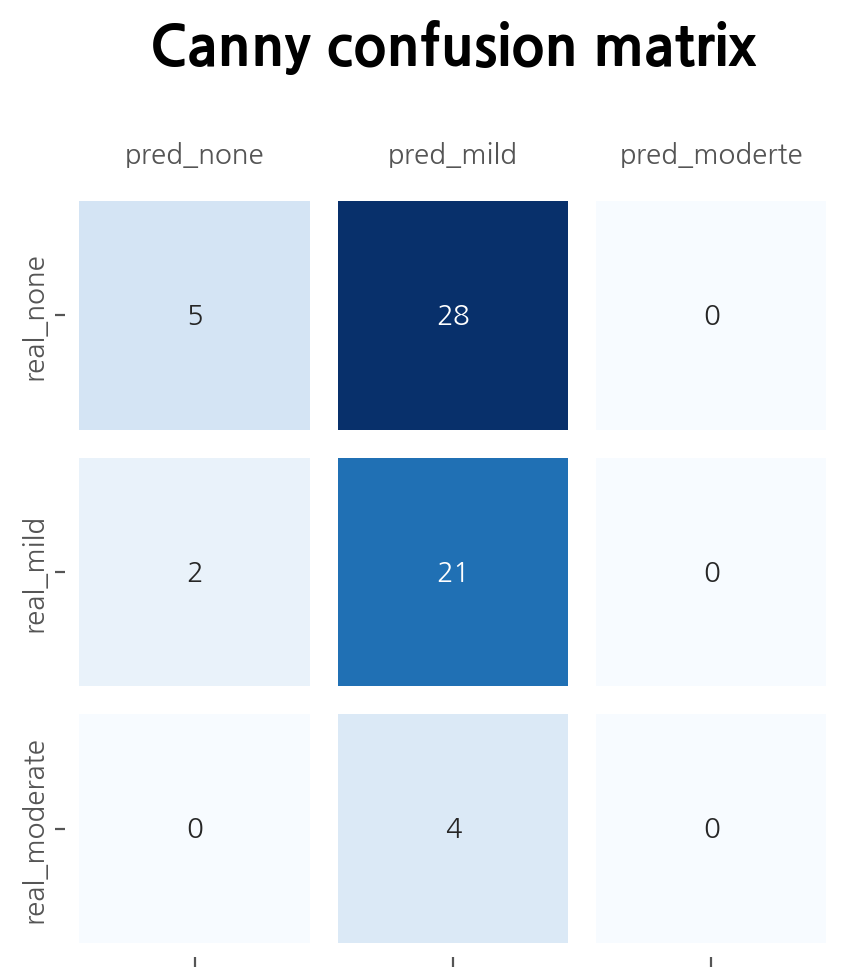

In [67]:
kimohchoi_cm(heemook, og_oas_X_test, og_oas_y_test)

In [57]:
heemook.evaluate(og_oas_X_test, og_oas_y_test)

2/2 [==============================] - 0s 50ms/step - loss: 13.5071 - accuracy: 0.4333


[13.507146835327148, 0.4333333373069763]

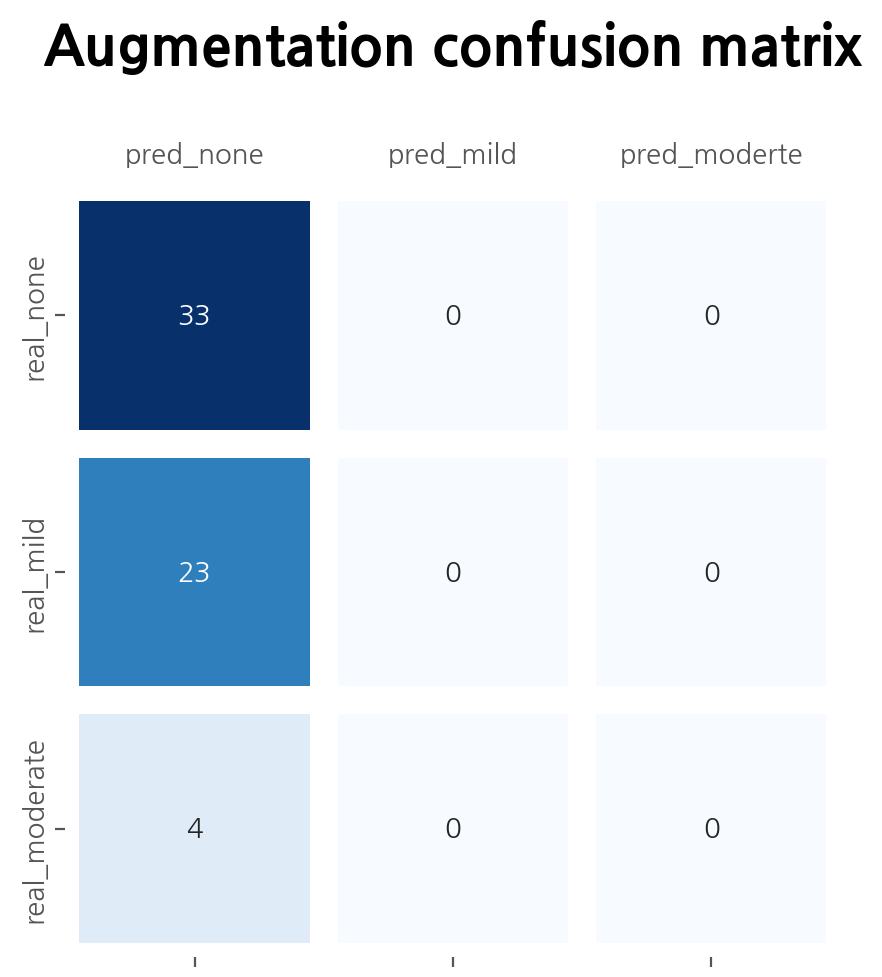

In [68]:
kimohchoi_cm(junghyun, og_oas_X_test, og_oas_y_test)

In [56]:
junghyun.evaluate(og_oas_X_test, og_oas_y_test)

2/2 [==============================] - 0s 5ms/step - loss: 3864.5625 - accuracy: 0.5500


[3864.5625, 0.550000011920929]

## ws_oas_X_test

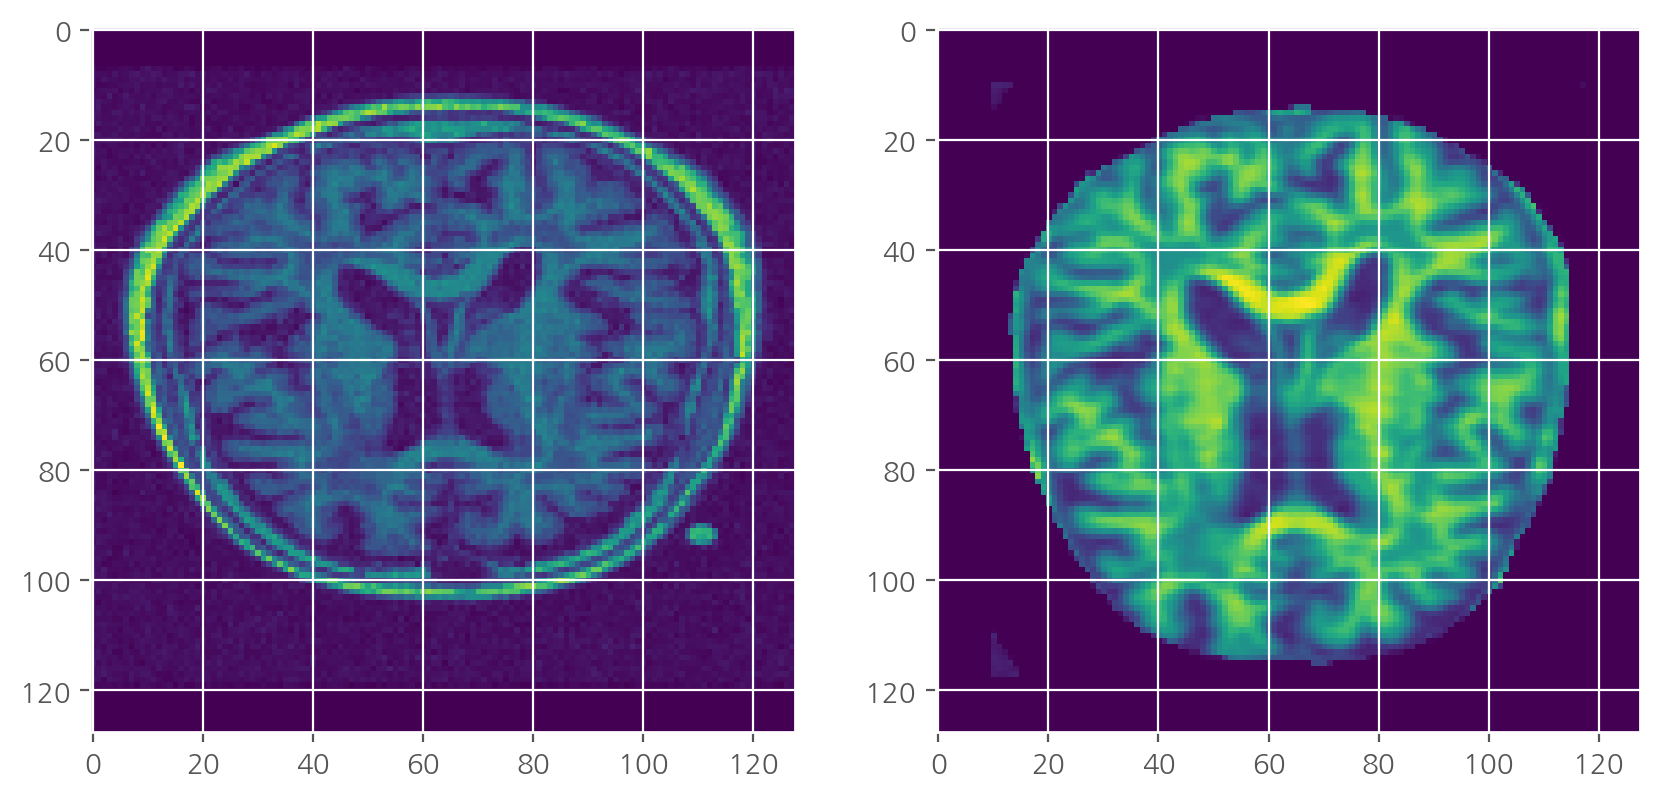

In [47]:
ws_oas_X_test = []
for img in og_oas_list:
    
    ws_img = img - np.min(img)
    ws_img = ws_img / np.max(ws_img) * 255
    ws_img = ws_img.astype(np.uint8)
    ws_img = preprocess_brain_img1(ws_img,skull_included = 1)
    ws_oas_X_test.append(ws_img)
# ws_oas_X_test[0]

fig, axis = plt.subplots(1,2,figsize = (10,5))
axis[0].imshow(og_oas_X_test[0]) # 원본
axis[1].imshow(ws_oas_X_test[0]) # 두개골 제거

In [48]:
ws_oas_X_test[0].shape
ws_oas_X_test = np.array(ws_oas_X_test)
ws_oas_X_test

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

## ws_oas_y_test

In [49]:
ws_oas_y_test = og_oas_y_test.copy()

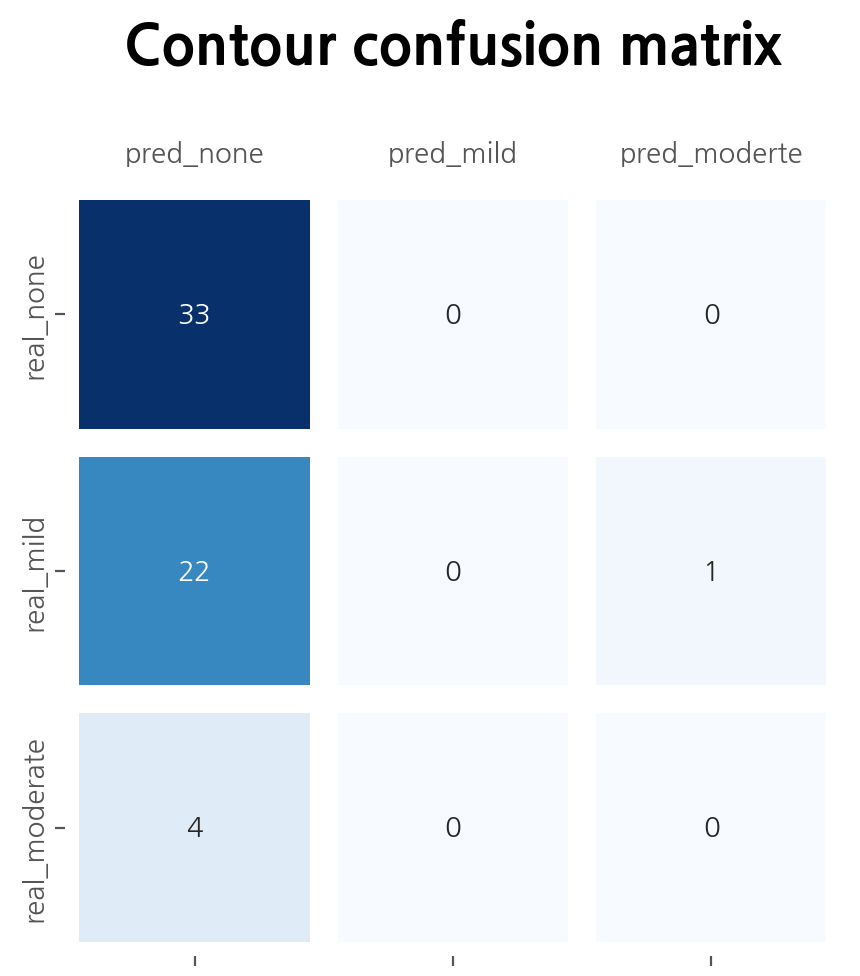

In [69]:
kimohchoi_cm(jesus, ws_oas_X_test, ws_oas_y_test)

In [55]:
jesus.evaluate(ws_oas_X_test, ws_oas_y_test)

2/2 [==============================] - 0s 16ms/step - loss: 1581.9617 - accuracy: 0.5500


[1581.961669921875, 0.550000011920929]

In [70]:
def comprehensive_cm(model, feature, label):
    fontdict = {'fontfamily':'serif', 'fontstyle':'italic'}
    if model == junghyun :
        name = 'Comprehensive model'

    y_pred = model.predict(feature, verbose=0)
    y_pred = [np.argmax(y) for y in y_pred]

    cm = confusion_matrix(label, y_pred)
    cm = pd.DataFrame(cm, columns=['pred_none', 'pred_mild', 'pred_moderte'], index=['real_none', 'real_mild', 'real_moderate'])

    plt.figure(figsize=(5, 5))
    ax = sns.heatmap(data=cm, annot=True, fmt='g', cmap='Blues', cbar=False, linewidths=10)

    ax.tick_params(axis='x', labeltop=True, labelbottom=False)
    ax.set_yticklabels(ax.get_yticklabels(), va='center')

    ax.set_title(f'{name} confusion matrix\n', fontsize=20, weight='bold') 


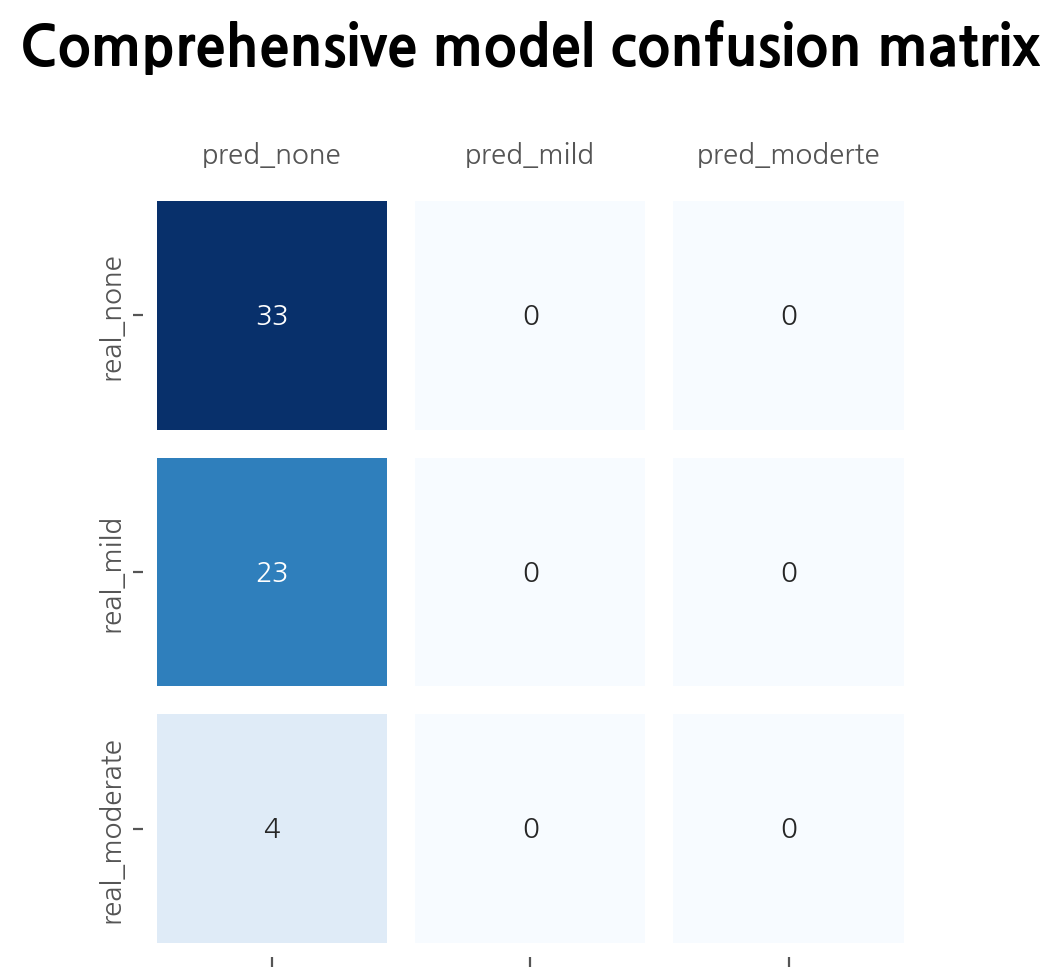

In [71]:
comprehensive_cm(junghyun, ws_oas_X_test, ws_oas_y_test)

In [53]:
def result_summary(model, X_test, y_test):
    """
    model, X_test, y_test를 입력하면 confusion matrix, classification report를 보여주고
    y_pred_label을 리턴하는 함수
    """
    # X_test에 대한 정답값 예측
    y_pred = model.predict(X_test, verbose=0);
    
    # argmax로 클래스 중 정답값 선택
    y_test_label = y_test
    y_pred_label = [np.argmax(y) for y in y_pred]

    # Classification Report
    clr = classification_report(y_test_label, y_pred_label)
    print("Classification Report\n----------------------\n", clr)

    # Confusion Matrix
    cm = confusion_matrix(y_test_label, y_pred_label)
    print("\n\nConfusion Matrix\n----------------------")
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual");

Classification Report
----------------------
               precision    recall  f1-score   support

           0       0.55      1.00      0.71        33
           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00         4

    accuracy                           0.55        60
   macro avg       0.18      0.33      0.24        60
weighted avg       0.30      0.55      0.39        60



Confusion Matrix
----------------------


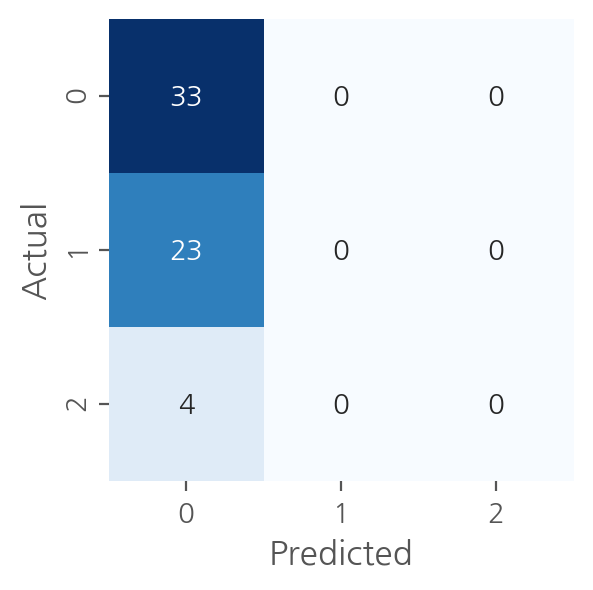

In [54]:
result_summary(junghyun, ws_oas_X_test, ws_oas_y_test)